In [ ]:
torch.cuda.is_available()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import copy
import os
import ssl
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

In [5]:
ssl._create_default_https_context = ssl._create_unverified_context
cudnn.benchmark = True
plt.ion()  # interactive mode
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [13]:
def main():
    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    data_dir = '/content/drive/MyDrive/Colab Notebooks/hymenoptera_data'
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'val']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                  shuffle=True, num_workers=4)
                   for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def imshow(inp, title=None):
        """Imshow for Tensor."""
        inp = inp.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        plt.imshow(inp)
        if title is not None:
            plt.title(title)
        plt.pause(0.001)  # pause a bit so that plots are updated

    # Get a batch of training data
    inputs, classes = next(iter(dataloaders['train']))

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)

    imshow(out, title=[class_names[x] for x in classes])

    def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
        since = time.time()

        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(best_model_wts)
        return model

    def visualize_model(model, num_images=6):
        was_training = model.training
        model.eval()
        images_so_far = 0
        fig = plt.figure()
    
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(dataloaders['val']):
                inputs = inputs.to(device)
                labels = labels.to(device)
    
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
    
                for j in range(inputs.size()[0]):
                    images_so_far += 1
                    ax = plt.subplot(num_images // 2, 2, images_so_far)
                    ax.axis('off')
                    ax.set_title(f'predicted: {class_names[preds[j]]}')
                    imshow(inputs.cpu().data[j])
    
                    if images_so_far == num_images:
                        model.train(mode=was_training)
                        return
            model.train(mode=was_training)

    model_ft = models.resnet18(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    # Here the size of each output sample is set to 2.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model_ft.fc = nn.Linear(num_ftrs, 2)

    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                           num_epochs=25)

    visualize_model(model_ft)

    model_conv = torchvision.models.resnet18(pretrained=True)
    for param in model_conv.parameters():
        param.requires_grad = False

    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, 2)

    model_conv = model_conv.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that only parameters of final layer are being optimized as
    # opposed to before.
    optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

    model_conv = train_model(model_conv, criterion, optimizer_conv,
                             exp_lr_scheduler, num_epochs=25)

    visualize_model(model_conv)

    plt.ioff()
    plt.show()

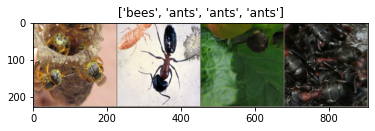

Epoch 0/24
----------
train Loss: 0.7204 Acc: 0.6680
val Loss: 0.2365 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.4033 Acc: 0.8238
val Loss: 0.2015 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.4649 Acc: 0.8197
val Loss: 0.2435 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.3158 Acc: 0.8811
val Loss: 0.1989 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.4335 Acc: 0.8484
val Loss: 0.2904 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.3616 Acc: 0.8689
val Loss: 0.6228 Acc: 0.8301

Epoch 6/24
----------
train Loss: 0.4834 Acc: 0.8074
val Loss: 0.2009 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.4484 Acc: 0.8197
val Loss: 0.1537 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.2725 Acc: 0.8689
val Loss: 0.1470 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.2885 Acc: 0.8689
val Loss: 0.1297 Acc: 0.9608

Epoch 10/24
----------
train Loss: 0.3222 Acc: 0.8730
val Loss: 0.1435 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.4109 Acc: 0.8279
val Loss: 0.1482 Acc: 0.9477

Ep

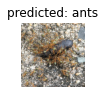

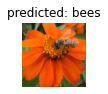

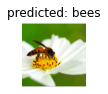

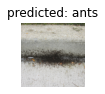

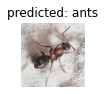

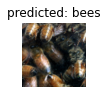

Epoch 0/24
----------
train Loss: 0.7396 Acc: 0.6639
val Loss: 1.1001 Acc: 0.5098

Epoch 1/24
----------
train Loss: 0.5331 Acc: 0.7459
val Loss: 0.2049 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.4049 Acc: 0.8156
val Loss: 0.1851 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.3379 Acc: 0.8730
val Loss: 0.4317 Acc: 0.8170

Epoch 4/24
----------
train Loss: 0.5169 Acc: 0.7582
val Loss: 0.2987 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.4619 Acc: 0.8361
val Loss: 0.2162 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.4556 Acc: 0.7992
val Loss: 0.4101 Acc: 0.8366

Epoch 7/24
----------
train Loss: 0.4385 Acc: 0.8033
val Loss: 0.1710 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3543 Acc: 0.8484
val Loss: 0.1729 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3379 Acc: 0.8320
val Loss: 0.1779 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3213 Acc: 0.8689
val Loss: 0.1681 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3284 Acc: 0.8648
val Loss: 0.1809 Acc: 0.9542

Ep

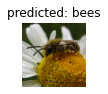

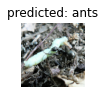

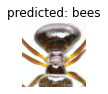

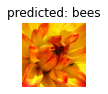

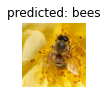

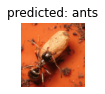

In [14]:
main()